Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


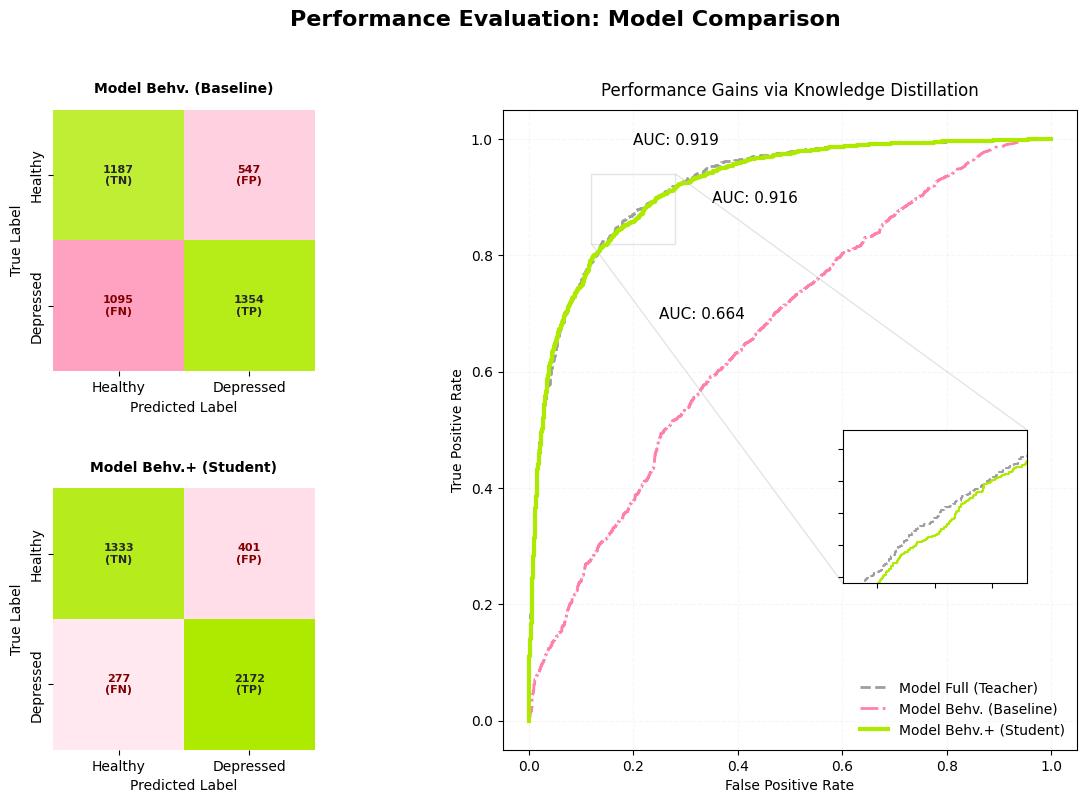


FINAL PERFORMANCE COMPARISON TABLE
                     Model Features  Accuracy    Recall        F1       AUC
      Model Full (Teacher)       46  0.842219  0.875459  0.866613  0.919268
    Model Behv. (Baseline)       10  0.607459  0.552879  0.622529   0.66351
    Model Behv.+ (Student)       10  0.837915  0.886893  0.864994  0.916055
LIFT (Student vs Baseline)        -   +37.94%   +60.41%   +38.95%   +38.06%


In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, recall_score, f1_score
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from google.colab import drive

from matplotlib.colors import LinearSegmentedColormap

# 1. 环境准备与数据加载
drive.mount('/content/drive')

PATHS = {
    "Model Behv.+": "/content/drive/MyDrive/CA6001_DEPRESSION_PROJECT/models/FINAL_STUDENT_NN_16_8_F08811.keras",
    "Model Behv.": "/content/drive/MyDrive/CA6001_DEPRESSION_PROJECT/models/nn_student_best_hard_baseline.keras",
    "Model Full": "/content/drive/MyDrive/CA6001_DEPRESSION_PROJECT/models/nn_teacher_best_cv.keras",
    "X_test": "/content/drive/MyDrive/CA6001_DEPRESSION_PROJECT/data/processed/X_test.csv",
    "y_test": "/content/drive/MyDrive/CA6001_DEPRESSION_PROJECT/data/processed/y_test.csv"
}

X_test = pd.read_csv(PATHS["X_test"])
y_test = pd.read_csv(PATHS["y_test"]).iloc[:, 0]

from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors

# 1. 颜色与色板定义 (修正了命名冲突)
COLOR_LIME_BRIGHT = "#AEEA00"
COLOR_SAKURA_BRIGHT = "#FF80AB"

# 创建纯净的单向渐变
cmap_lime_clean = mcolors.LinearSegmentedColormap.from_list("LimeClean", ["#FFFFFF", COLOR_LIME_BRIGHT])
cmap_sakura_clean = mcolors.LinearSegmentedColormap.from_list("SakuraClean", ["#FFFFFF", COLOR_SAKURA_BRIGHT])

# 2. 修正后的绘图函数 (确保 vmax 被正确应用)
def draw_final_themed_cm(cm, ax, title):
    tn, fp, fn, tp = cm.ravel()
    labels = np.array([[f"{tn}\n(TN)", f"{fp}\n(FP)"], [f"{fn}\n(FN)", f"{tp}\n(TP)"]])

    # --- 核心修复：强制全局饱和刻度 ---
    FIXED_VMAX = 1500

    # 构造颜色映射矩阵
    correct_data = np.array([[tn, 0], [0, tp]], dtype=float)
    error_data = np.array([[0, fp], [fn, 0]], dtype=float)

    # 1. 绘制正确预测 (青柠绿层) - 使用 cmap_lime_clean
    sns.heatmap(correct_data, annot=labels, fmt="", cmap=cmap_lime_clean,
                cbar=False, ax=ax, square=True,
                mask=(correct_data == 0),
                vmax=FIXED_VMAX, vmin=0,
                annot_kws={"size": 8, "fontweight": "bold"})

    # 2. 绘制错误预测 (亮粉色层) - 使用 cmap_sakura_clean
    sns.heatmap(error_data, annot=labels, fmt="", cmap=cmap_sakura_clean,
                cbar=False, ax=ax, square=True,
                mask=(error_data == 0),
                vmax=FIXED_VMAX, vmin=0,
                annot_kws={"size": 8, "fontweight": "bold", "color": "#800000"})

    ax.set_title(title, fontsize=10, fontweight='bold', pad=10)
    ax.set_xticklabels(['Healthy', 'Depressed'])
    ax.set_yticklabels(['Healthy', 'Depressed'])
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

# 3. 综合排版与绘图 (重点优化：布局与留白)
# -------------------------------------------------------
# 保持画布大小，但通过边距控制实际内容大小
fig = plt.figure(figsize=(16, 10), facecolor='white')

# 总标题居中，y值微调
fig.suptitle("Performance Evaluation: Model Comparison",
             fontsize=16, fontweight='bold', y=0.92)

# 调整子图比例
gs = fig.add_gridspec(2, 2, width_ratios=[1, 2.2], wspace=0.45, hspace=0.45)

# A. 左侧：双色混淆矩阵
for i, name in enumerate(["Model Behv. (Baseline)", "Model Behv.+ (Student)"]):
    ax = fig.add_subplot(gs[i, 0])
    cm = confusion_matrix(y_test, results[name]["pred"])
    draw_final_themed_cm(cm, ax, name)
    ax.set_title(name, fontsize=10, fontweight='bold', pad=12)

# --- B. 右侧：ROC 曲线对比 (调整标签为细体) ---
ax_roc = fig.add_subplot(gs[:, 1])

# 重新校准标签位置，避开放大镜
label_positions = {
    "Model Full (Teacher)": (0.20, 0.99),
    "Model Behv.+ (Student)": (0.35, 0.89),
    "Model Behv. (Baseline)": (0.25, 0.69)
}

for name, cfg in models_info.items():
    res = results[name]
    lw = 3.0 if '+' in name else 2.0

    # 1. 绘制曲线
    ax_roc.plot(res["fpr"], res["tpr"], color=cfg["color"],
                linestyle=cfg["ls"], linewidth=lw,
                label=name)

    # 2. 【核心优化】AUC 改为细体黑字
    pos_x, pos_y = label_positions.get(name, (0.5, 0.5))

    ax_roc.text(pos_x, pos_y, f"AUC: {res['auc']:.3f}",
                fontsize=11, fontweight='normal', # 这里改为 normal (细体)
                color='black',                    # 统一使用黑字
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

# C. 局部放大镜 (位置微调)
ax_ins = zoomed_inset_axes(ax_roc, zoom=2.2, loc='center left',
                           bbox_to_anchor=(0.58, 0.38), bbox_transform=ax_roc.transAxes)
for name, cfg in models_info.items():
    ax_ins.plot(results[name]["fpr"], results[name]["tpr"],
                color=cfg["color"], linestyle=cfg["ls"], linewidth=1.5)

ax_ins.set_xlim(0.12, 0.28)
ax_ins.set_ylim(0.82, 0.94)
mark_inset(ax_roc, ax_ins, loc1=1, loc2=3, fc="none", ec="#BDBDBD", alpha=0.4)
plt.setp(ax_ins.get_xticklabels(), visible=False)
plt.setp(ax_ins.get_yticklabels(), visible=False)

# 修饰图表
ax_roc.set_title("Performance Gains via Knowledge Distillation", fontsize=12, pad=10)
ax_roc.set_xlabel("False Positive Rate", fontsize=10)
ax_roc.set_ylabel("True Positive Rate", fontsize=10)
ax_roc.grid(True, alpha=0.1, linestyle='--')
ax_roc.legend(loc='lower right', frameon=False, fontsize=10)

# 【核心布局修改】大幅度增加四周白边
# left, bottom 增大；right, top 减小
plt.subplots_adjust(
    left=0.18,    # 左侧留白增加
    right=0.82,   # 右侧留白增加
    top=0.82,     # 顶部标题留位增加
    bottom=0.18,  # 底部留白增加
    wspace=0.5,   # 子图间距
    hspace=0.5
)

plt.show()

# 6. 打印性能行对比表 (Row-wise Lift)
df_res = pd.DataFrame(perf_list)
# 提取数值用于计算 Lift
metrics_cols = ['Accuracy', 'Recall', 'F1', 'AUC']
base_vals = df_res.iloc[1][metrics_cols].values.astype(float)
stud_vals = df_res.iloc[2][metrics_cols].values.astype(float)

lift_vals = ((stud_vals - base_vals) / base_vals * 100)
lift_row = {
    "Model": "LIFT (Student vs Baseline)",
    "Features": "-",
    "Accuracy": f"+{lift_vals[0]:.2f}%",
    "Recall": f"+{lift_vals[1]:.2f}%",
    "F1": f"+{lift_vals[2]:.2f}%",
    "AUC": f"+{lift_vals[3]:.2f}%"
}

df_final = pd.concat([df_res, pd.DataFrame([lift_row])], ignore_index=True)

print("\n" + "="*95 + "\nFINAL PERFORMANCE COMPARISON TABLE\n" + "="*95)
print(df_final.to_string(index=False))

In [96]:
from tensorflow.keras.models import load_model

# 1. 确保路径与你之前的定义一致
PATHS = {
    "Model Behv.+": "/content/drive/MyDrive/CA6001_DEPRESSION_PROJECT/models/FINAL_STUDENT_NN_16_8_F08811.keras",
    "Model Behv.": "/content/drive/MyDrive/CA6001_DEPRESSION_PROJECT/models/nn_student_best_hard_baseline.keras"
}

# 2. 加载模型并重命名为代码中使用的变量名
# 注意：这里我们将 "Model Behv." 加载为 model_behv
# 将 "Model Behv.+" 加载为 model_behv_plus
print("正在加载模型，请稍候...")
model_behv = load_model(PATHS["Model Behv."])
model_behv_plus = load_model(PATHS["Model Behv.+"])

print("✅ 模型加载成功！现在可以重新运行 3D 绘图代码了。")

正在加载模型，请稍候...
✅ 模型加载成功！现在可以重新运行 3D 绘图代码了。


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


正在计算三个模型的预测概率...


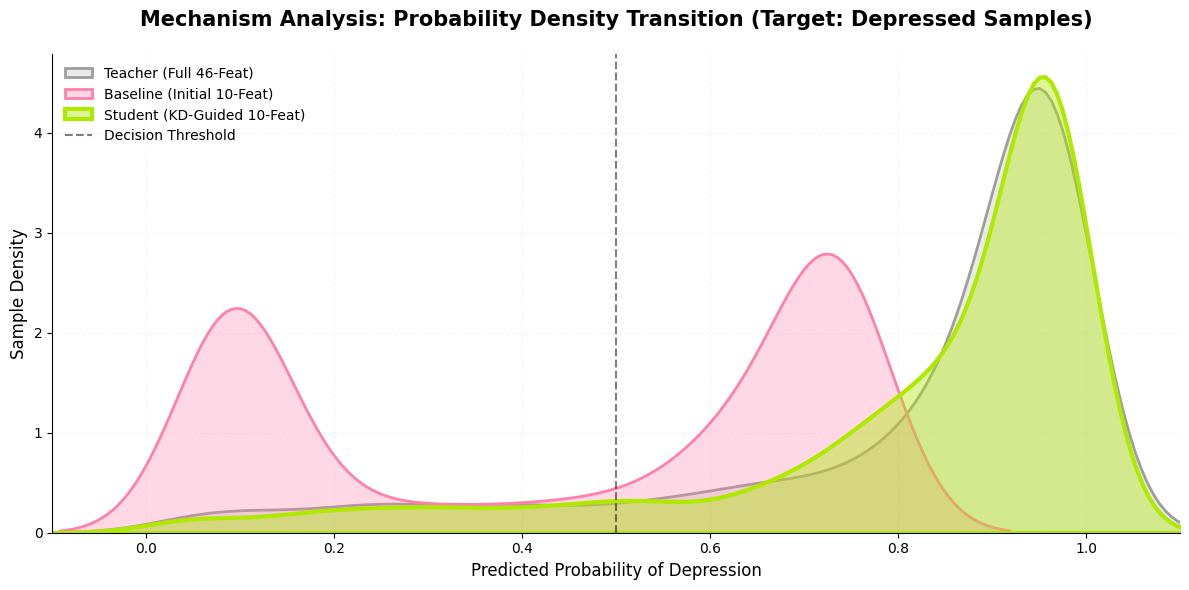

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_triple_probability_density_fixed(model_base, model_stud, model_teach, X_test_10, X_test_46, y_test):
    """
    model_base: 10维 Baseline
    model_stud: 10维 Student
    model_teach: 46维 Teacher
    """
    # 1. 执行预测并强制转换为扁平数组
    print("正在计算三个模型的预测概率...")
    prob_base = model_base.predict(X_test_10, verbose=0).ravel()
    prob_stud = model_stud.predict(X_test_10, verbose=0).ravel()
    prob_teach = model_teach.predict(X_test_46, verbose=0).ravel()

    # 2. 【核心修复】构造一个干净的 DataFrame，确保索引自动对齐
    # 我们直接取 y_test 的 values，丢弃原始可能冲突的索引
    plot_df = pd.DataFrame({
        'prob_baseline': prob_base,
        'prob_student': prob_stud,
        'prob_teacher': prob_teach,
        'true_label': y_test.values  # 使用 .values 确保只有数据，不带旧索引
    })

    # 3. 筛选真实抑郁样本 (True Positives)
    depressed_data = plot_df[plot_df['true_label'] == 1]

    # 4. 绘图
    plt.figure(figsize=(12, 6), facecolor='white')

    # Teacher: 灰色 (作为知识源头)
    sns.kdeplot(depressed_data['prob_teacher'], label='Teacher (Full 46-Feat)',
                fill=True, color='#9E9E9E', alpha=0.2, linewidth=2)

    # Baseline: 粉色 (未蒸馏)
    sns.kdeplot(depressed_data['prob_baseline'], label='Baseline (Initial 10-Feat)',
                fill=True, color='#FF80AB', alpha=0.3, linewidth=2)

    # Student: 青柠色 (KD 引导后)
    sns.kdeplot(depressed_data['prob_student'], label='Student (KD-Guided 10-Feat)',
                fill=True, color='#AEEA00', alpha=0.4, linewidth=3)

    plt.axvline(0.5, color='black', linestyle='--', alpha=0.5, label='Decision Threshold')

    plt.title("Mechanism Analysis: Probability Density Transition (Target: Depressed Samples)",
              fontsize=15, fontweight='bold', pad=20)
    plt.xlabel("Predicted Probability of Depression", fontsize=12)
    plt.ylabel("Sample Density", fontsize=12)
    plt.xlim(-0.1, 1.1)
    plt.legend(frameon=False, loc='upper left')
    plt.grid(alpha=0.1, linestyle='--')
    sns.despine()
    plt.tight_layout()
    plt.show()

# --- 准备数据并运行 ---
# 请确保 X_test 是 46 维的，而 X_test_10 是前 10 维
X_test_10_vals = X_test.iloc[:, :10].values
X_test_46_vals = X_test.values

plot_triple_probability_density_fixed(
    model_behv,          # Baseline
    model_behv_plus,     # Student
    model_full,          # Teacher (46维)
    X_test_10_vals,
    X_test_46_vals,
    y_test
)

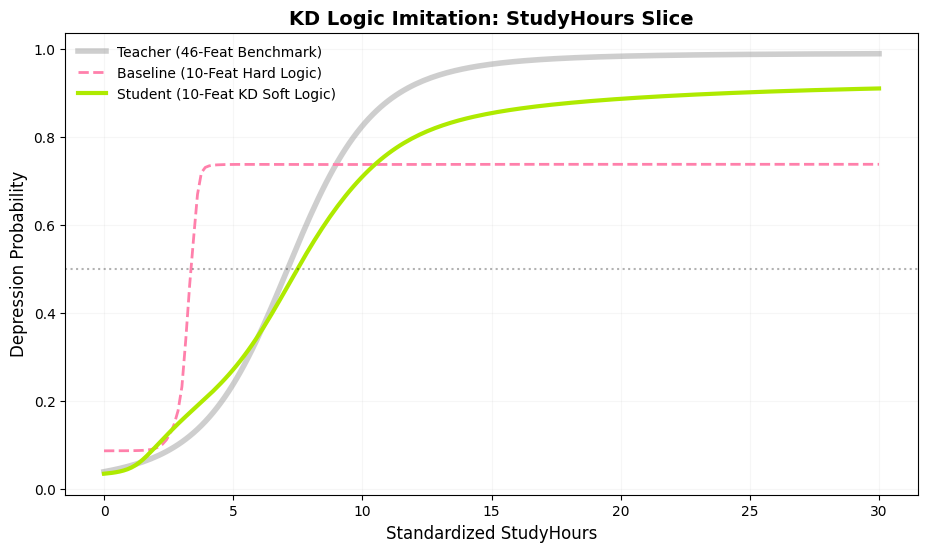

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

def plot_triple_decision_slice(model_base, model_stud, model_teach, X_sample_full, feature_idx, feature_name, val_range):
    # 1. 构造 46 维模拟数据
    X_sim_full = np.tile(X_sample_full.values, (len(val_range), 1))
    X_sim_full[:, feature_idx] = val_range

    # 2. 准备各自的输入维度
    X_sim_10 = X_sim_full[:, :10]   # Baseline 和 Student 用前10维
    X_sim_46 = X_sim_full           # Teacher 用全量46维

    # 3. 推理
    prob_base = model_base.predict(X_sim_10, verbose=0).ravel()
    prob_stud = model_stud.predict(X_sim_10, verbose=0).ravel()
    prob_teach = model_teach.predict(X_sim_46, verbose=0).ravel()

    # 4. 绘图
    plt.figure(figsize=(11, 6), facecolor='white')

    # Teacher: 灰色粗实线 (作为真理/标杆)
    plt.plot(val_range, prob_teach, label='Teacher (46-Feat Benchmark)',
             color='#9E9E9E', linewidth=4, alpha=0.5)

    # Baseline: 粉色虚线 (反面教材)
    plt.plot(val_range, prob_base, label='Baseline (10-Feat Hard Logic)',
             color='#FF80AB', linewidth=2, linestyle='--')

    # Student: 青柠色实线 (KD 成果)
    plt.plot(val_range, prob_stud, label='Student (10-Feat KD Soft Logic)',
             color='#AEEA00', linewidth=3)

    plt.axhline(0.5, color='black', linestyle=':', alpha=0.3)

    plt.title(f"KD Logic Imitation: {feature_name} Slice", fontsize=14, fontweight='bold')
    plt.xlabel(f"Standardized {feature_name}", fontsize=12)
    plt.ylabel("Depression Probability", fontsize=12)
    plt.legend(frameon=False, loc='upper left')
    plt.grid(alpha=0.1)
    plt.show()

# 调用 (需确保 model_full 已经加载)
#plot_triple_decision_slice(model_behv, model_behv_plus, model_full, test_sample, col_idx, 'StudyHours', v_range)
# --- 执行调用 ---
# 确保使用 StudyHours
target_feature = 'StudyHours'
if target_feature in X_test.columns:
    # 获取特征在 46 维中的索引位置
    col_idx = X_test.columns.get_loc(target_feature)

    # 选一个具有代表性的样本（比如索引为 5 的测试样本）
    # 确保这个样本在基础特征下具有观察意义
    test_sample = X_test.iloc[5]

    # 变化范围 (-3 到 3)
    v_range = np.linspace(0, 30, 200)

    # 运行函数
    plot_triple_decision_slice(model_behv, model_behv_plus, model_full, test_sample, col_idx, 'StudyHours', v_range)
else:
    print(f"找不到特征 {target_feature}")

正在提取三个模型的潜在空间特征...


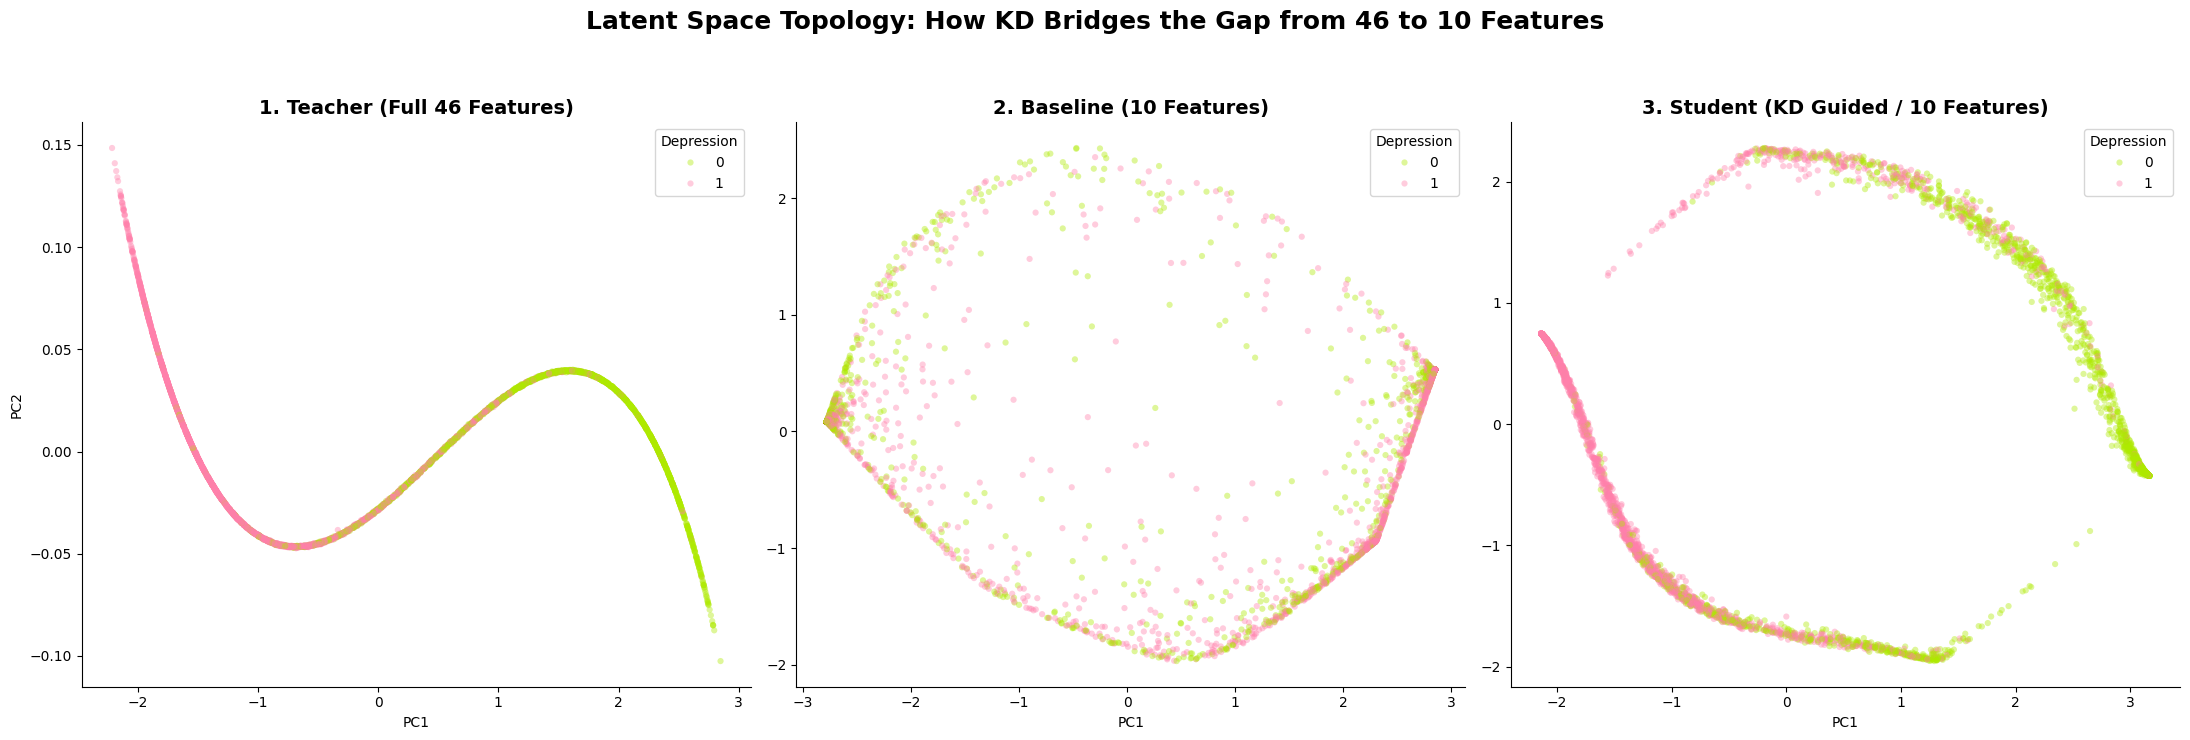

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

# ==========================================
# 1. 提取潜在特征的通用函数 (避开 AttributeError)
# ==========================================
def get_latent_features_robust(model, data):
    """
    通过逐层遍历直到倒数第二层来提取特征，确保兼容性。
    """
    x = data
    # 遍历直到最后一层（Output层）之前
    for layer in model.layers[:-1]:
        x = layer(x)
    return x.numpy() if hasattr(x, 'numpy') else x

# ==========================================
# 2. 准备数据与提取特征
# ==========================================
print("正在提取三个模型的潜在空间特征...")

# 假设 X_test 包含所有 46 个特征
# X_test_10 为前 10 个行为特征，X_test_46 为全量特征
X_test_10 = X_test.iloc[:, :10].values.astype('float32')
X_test_46 = X_test.values.astype('float32')

# 提取特征
# Teacher (46维输入)
feat_teach = get_latent_features_robust(model_full, X_test_46)
# Baseline (10维输入)
feat_base = get_latent_features_robust(model_behv, X_test_10)
# Student (10维输入)
feat_stud = get_latent_features_robust(model_behv_plus, X_test_10)

# ==========================================
# 3. 执行 PCA 降维
# ==========================================
pca = PCA(n_components=2, random_state=42)

pca_teach = pca.fit_transform(feat_teach)
pca_base = pca.fit_transform(feat_base)
pca_stud = pca.fit_transform(feat_stud)

# ==========================================
# 4. 三位一体可视化对比
# ==========================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7), facecolor='white')
colors = ['#AEEA00', '#FF80AB'] # 健康 vs 抑郁

# A. Teacher PCA (理想状态/黄金标准)
sns.scatterplot(x=pca_teach[:, 0], y=pca_teach[:, 1], hue=y_test,
                palette=colors, alpha=0.4, ax=ax1, s=20, edgecolor='none')
ax1.set_title("1. Teacher (Full 46 Features)", fontsize=14, fontweight='bold')
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")

# B. Baseline PCA (未蒸馏的 10 维模型)
sns.scatterplot(x=pca_base[:, 0], y=pca_base[:, 1], hue=y_test,
                palette=colors, alpha=0.4, ax=ax2, s=20, edgecolor='none')
ax2.set_title("2. Baseline (10 Features)", fontsize=14, fontweight='bold')
ax2.set_xlabel("PC1")

# C. Student PCA (蒸馏后的 10 维模型)
sns.scatterplot(x=pca_stud[:, 0], y=pca_stud[:, 1], hue=y_test,
                palette=colors, alpha=0.4, ax=ax3, s=20, edgecolor='none')
ax3.set_title("3. Student (KD Guided / 10 Features)", fontsize=14, fontweight='bold')
ax3.set_xlabel("PC1")

# 统一布局
plt.suptitle("Latent Space Topology: How KD Bridges the Gap from 46 to 10 Features",
             fontsize=18, fontweight='bold', y=1.05)
sns.despine()
plt.tight_layout()
plt.show()

<>:32: SyntaxWarning:

invalid escape sequence '\m'

<>:51: SyntaxWarning:

invalid escape sequence '\m'

<>:32: SyntaxWarning:

invalid escape sequence '\m'

<>:51: SyntaxWarning:

invalid escape sequence '\m'

/tmp/ipython-input-657125892.py:32: SyntaxWarning:

invalid escape sequence '\m'

/tmp/ipython-input-657125892.py:51: SyntaxWarning:

invalid escape sequence '\m'



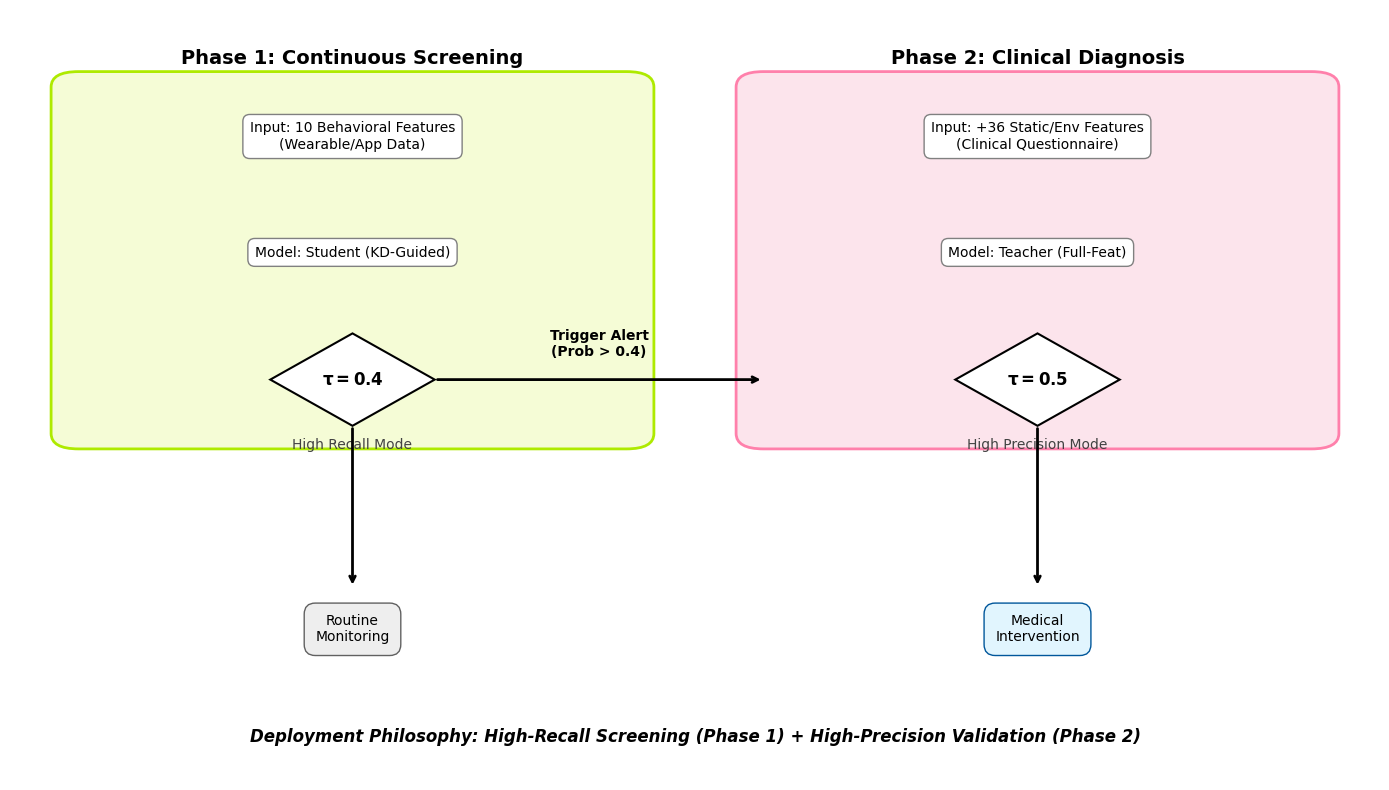

In [132]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_deployment_workflow():
    fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.axis('off')

    # 定义颜色 (保持与你之前图表一致)
    color_s1 = "#f5fcd6"  # 背景绿
    edge_s1 = "#AEEA00"   # 边框绿
    color_s2 = "#fce4ec"  # 背景粉
    edge_s2 = "#FF80AB"   # 边框粉

    # --- Phase 1: Screening ---
    # 外框
    rect1 = patches.FancyBboxPatch((5, 45), 40, 45, boxstyle="round,pad=2",
                                   ec=edge_s1, fc=color_s1, lw=2)
    ax.add_patch(rect1)
    ax.text(25, 93, "Phase 1: Continuous Screening", fontsize=14, fontweight='bold', ha='center')

    # S1 内容块
    ax.text(25, 82, "Input: 10 Behavioral Features\n(Wearable/App Data)",
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="grey", lw=1), ha='center')
    ax.text(25, 68, "Model: Student (KD-Guided)",
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="grey", lw=1), ha='center')

    # S1 决策节点
    diamond1 = patches.RegularPolygon((25, 52), 4, radius=6, orientation=0, ec="black", fc="white", lw=1.5)
    ax.add_patch(diamond1)
    ax.text(25, 52, "$\mathbf{\\tau = 0.4}$", ha='center', va='center', fontsize=12, fontweight='bold')
    ax.text(25, 43, "High Recall Mode", ha='center', fontsize=10, color="#424242")

    # --- Phase 2: Diagnosis ---
    # 外框
    rect2 = patches.FancyBboxPatch((55, 45), 40, 45, boxstyle="round,pad=2",
                                   ec=edge_s2, fc=color_s2, lw=2)
    ax.add_patch(rect2)
    ax.text(75, 93, "Phase 2: Clinical Diagnosis", fontsize=14, fontweight='bold', ha='center')

    # S2 内容块
    ax.text(75, 82, "Input: +36 Static/Env Features\n(Clinical Questionnaire)",
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="grey", lw=1), ha='center')
    ax.text(75, 68, "Model: Teacher (Full-Feat)",
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="grey", lw=1), ha='center')

    # S2 决策节点
    diamond2 = patches.RegularPolygon((75, 52), 4, radius=6, orientation=0, ec="black", fc="white", lw=1.5)
    ax.add_patch(diamond2)
    ax.text(75, 52, "$\mathbf{\\tau = 0.5}$", ha='center', va='center', fontsize=12, fontweight='bold')
    ax.text(75, 43, "High Precision Mode", ha='center', fontsize=10, color="#424242")

    # --- 连接箭头 ---
    # Phase 1 -> Phase 2
    ax.annotate("", xy=(55, 52), xytext=(31, 52),
                arrowprops=dict(arrowstyle="->", lw=2, color="black"))
    ax.text(43, 55, "Trigger Alert\n(Prob > 0.4)", ha='center', fontsize=10, fontweight='bold')

    # Phase 2 -> Intervention
    ax.annotate("", xy=(75, 25), xytext=(75, 46),
                arrowprops=dict(arrowstyle="->", lw=2, color="black"))
    ax.text(75, 18, "Medical\nIntervention", bbox=dict(boxstyle="round,pad=0.8", fc="#e1f5fe", ec="#01579b"), ha='center')

    # Phase 1 -> Monitor
    ax.annotate("", xy=(25, 25), xytext=(25, 46),
                arrowprops=dict(arrowstyle="->", lw=2, color="black"))
    ax.text(25, 18, "Routine\nMonitoring", bbox=dict(boxstyle="round,pad=0.8", fc="#eeeeee", ec="#616161"), ha='center')

    # --- 底部核心解释 ---
    ax.text(50, 5, "Deployment Philosophy: High-Recall Screening (Phase 1) + High-Precision Validation (Phase 2)",
            ha='center', fontsize=12, fontstyle='italic', fontweight='bold')

    plt.tight_layout()
    plt.show()

draw_deployment_workflow()

In [133]:
import pandas as pd
from sklearn.metrics import recall_score, precision_score, f1_score

def analyze_threshold_impact(model_base, model_stud, X_test_10, y_test):
    # 获取预测概率
    prob_base = model_base.predict(X_test_10, verbose=0).ravel()
    prob_stud = model_stud.predict(X_test_10, verbose=0).ravel()

    thresholds = [0.3, 0.4, 0.5]
    results_list = []

    for th in thresholds:
        # 对 Baseline 计算
        pred_base = (prob_base > th).astype(int)
        results_list.append({
            "Model": "Baseline",
            "Threshold": th,
            "Recall": recall_score(y_test, pred_base),
            "Precision": precision_score(y_test, pred_base),
            "F1": f1_score(y_test, pred_base)
        })

        # 对 Student 计算
        pred_stud = (prob_stud > th).astype(int)
        results_list.append({
            "Model": "Student (KD)",
            "Threshold": th,
            "Recall": recall_score(y_test, pred_stud),
            "Precision": precision_score(y_test, pred_stud),
            "F1": f1_score(y_test, pred_stud)
        })

    return pd.DataFrame(results_list)

# 执行分析
X_test_10 = X_test.iloc[:, :10].values
df_thresholds = analyze_threshold_impact(model_behv, model_behv_plus, X_test_10, y_test)

print("\n" + "="*60)
print("THRESHOLD SENSITIVITY ANALYSIS (PHASE 1 STRATEGY)")
print("="*60)
print(df_thresholds.to_string(index=False))


THRESHOLD SENSITIVITY ANALYSIS (PHASE 1 STRATEGY)
       Model  Threshold   Recall  Precision       F1
    Baseline        0.3 0.614128   0.695331 0.652212
Student (KD)        0.3 0.940384   0.793864 0.860935
    Baseline        0.4 0.587178   0.706287 0.641249
Student (KD)        0.4 0.915067   0.822084 0.866087
    Baseline        0.5 0.552879   0.712257 0.622529
Student (KD)        0.5 0.886893   0.844151 0.864994


In [94]:
# 打印所有列名，确认前缀
print([col for col in df_encoded.columns if 'sleep' in col.lower() or 'diet' in col.lower()])

['DietHabit_Healthy', 'DietHabit_Moderate', 'DietHabit_Others', 'DietHabit_Unhealthy', 'SleepDur_5-6 hours', 'SleepDur_7-8 hours', 'SleepDur_Less than 5 hours', 'SleepDur_More than 8 hours', 'SleepDur_Others']


In [2]:
import pandas as pd

# 1. 定义核心数据（已对齐所有实验结果）
data = {
    "Model": [
        "Full (Teacher)",
        "Behv. (Baseline)",
        "Behv.+ (Default)",
        "Behv.+ (Screening)",
        "Behv.+ (Extreme)"
    ],
    "Feat.": [46, 10, 10, 10, 10],
    "Threshold": [0.5, 0.5, 0.5, 0.4, 0.3],
    "Acc.": [0.8422, 0.6075, 0.8379, 0.8265, 0.7952],
    "Recall": [0.8755, 0.5529, 0.8869, 0.9151, 0.9404],
    "Prec.": [0.8579, 0.7123, 0.8442, 0.8221, 0.7939],
    "F1": [0.8666, 0.6225, 0.8650, 0.8661, 0.8609],
    "AUC": [0.9193, 0.6635, 0.9161, 0.9161, 0.9161]
}

df = pd.DataFrame(data)

# 2. 计算知识蒸馏带来的核心提升 (KD Lift)
# 对比对象：Behv.+ (Default) vs Behv. (Baseline)
metrics = ["Acc.", "Recall", "Prec.", "F1", "AUC"]
base_vals = df.iloc[1][metrics].values.astype(float)
stud_vals = df.iloc[2][metrics].values.astype(float)
lift_vals = (stud_vals - base_vals) / base_vals * 100

# 3. 构造 Lift 行
lift_row = pd.DataFrame({
    "Model": ["KD Lift (%)"],
    "Feat.": ["-"],
    "Threshold": ["-"],
    "Acc.": [f"+{lift_vals[0]:.1f}%"],
    "Recall": [f"+{lift_vals[1]:.1f}%"],
    "Prec.": [f"+{lift_vals[2]:.1f}%"],
    "F1": [f"+{lift_vals[3]:.1f}%"],
    "AUC": [f"+{lift_vals[4]:.1f}%"]
})

# 4. 合并最终表格
df_final = pd.concat([df, lift_row], ignore_index=True)

# 5. 打印输出
print("\n" + "="*95)
print("FINAL INTEGRATED EVALUATION: COMPREHENSIVE PERFORMANCE & STRATEGY ANALYSIS")
print("="*95)
print(df_final.to_string(index=False, justify='center'))


FINAL INTEGRATED EVALUATION: COMPREHENSIVE PERFORMANCE & STRATEGY ANALYSIS
      Model        Feat. Threshold   Acc.   Recall  Prec.     F1     AUC  
    Full (Teacher)   46      0.5    0.8422  0.8755  0.8579  0.8666  0.9193
  Behv. (Baseline)   10      0.5    0.6075  0.5529  0.7123  0.6225  0.6635
  Behv.+ (Default)   10      0.5    0.8379  0.8869  0.8442   0.865  0.9161
Behv.+ (Screening)   10      0.4    0.8265  0.9151  0.8221  0.8661  0.9161
  Behv.+ (Extreme)   10      0.3    0.7952  0.9404  0.7939  0.8609  0.9161
       KD Lift (%)    -        -    +37.9%  +60.4%  +18.5%  +39.0%  +38.1%
